## <center> **Анализ результатов A/B-тестирования**

Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы официального сайта компании и провела A/B-тестирование. Собранные в результате проведения эксперимента данные вы можете найти здесь.

Вам предстоит решить настоящую бизнес-задачу: проанализировать эффективность обоих вариантов посадочной страницы сразу по двум критериям: конверсии покупки и среднему чеку. На основе проведенного анализа вам будет необходимо сделать выводы и принять решение: какой из вариантов дизайна более предпочтительный.

Итак, наша фирма предлагает следующие варианты туров и их соответствующие стоимости:
* Таиланд — 100000 рублей;
* Турция — 60000 рублей;
* Мальдивы — 200000 рублей;
* Санкт-Петербург — 10000 рублей;
* Камчатка — 150000 рублей.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_ind, shapiro, f_oneway, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest

Прочитаем наши данные и посмотрим на столбцы таблицы:

In [2]:
data = pd.read_csv('data/ab_data_tourist.csv')
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


## **Задание 7.1.**

Начнем с исследования структуры наших данных. С помощью метода info() выведите информацию о типах данных и количестве непустых значений. Какой тип данных имеет столбец date?

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


## **Задание 7.2.**

Приведите столбец date к типу данных datetime. Убедитесь в равной длительности проведения тестирования для каждой из группы. Для этого сгруппируйте данные по признаку группы и определите первую и последнюю дату наблюдения для каждой из групп. 

В какой промежуток времени проводился A/B-тест?


In [4]:
data['date'] = pd.to_datetime(data['date'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   user_id   294478 non-null  int64         
 1   date      294478 non-null  datetime64[ns]
 2   group     294478 non-null  object        
 3   purchase  294478 non-null  int64         
 4   price     294478 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 11.2+ MB


In [5]:
data_a = data[data['group'] == 'A'].sort_values('date')
data_b = data[data['group'] == 'B'].sort_values('date')
start_a = data_a['date'].iloc[0]
start_b = data_b['date'].iloc[0]
finish_a = data_a['date'].iloc[-1]
finish_b = data_b['date'].iloc[-1]
print(f'Дата первой записи для группы А - {start_a:%d.%m.%Y}, для группы В - {start_b:%d.%m.%Y}.')
print(f'Дата последней записи для группы А - {finish_a:%d.%m.%Y}, для группы В - {finish_b:%d.%m.%Y}.')

Дата первой записи для группы А - 02.01.2021, для группы В - 02.01.2021.
Дата последней записи для группы А - 24.01.2021, для группы В - 24.01.2021.


## **Задание 7.3.**

* Чему равно количество посещений сайта в группах А и B?

* Чему равно суммарное количество покупок в группах А и B?

* Чему равна сумма всех покупок в группах А и B? Ответ приведите в миллионах рублей. Например, 185.52 млн. руб.

In [6]:
count_a = data_a.shape[0]
count_b = data_b.shape[0]
count_purchase_a = data_a['purchase'].sum()
count_purchase_b = data_b['purchase'].sum()
bill_a = data_a['price'].sum()
bill_b = data_b['price'].sum()
print(f'Количество посещений в группах А и В равно соответственно {count_a}, {count_b}')
print(f'Количество покупок при этом в группе А {count_purchase_a} раз на сумму {bill_a / 1000000} миллионов рублей, \
в группе В - {count_purchase_b} раз на сумму {bill_b / 1000000} миллионов рублей')

Количество посещений в группах А и В равно соответственно 147202, 147276
Количество покупок при этом в группе А 17723 раз на сумму 1436.26 миллионов рублей, в группе В - 17514 раз на сумму 1554.1 миллионов рублей


## **Задание 7.4.**

Проверьте, есть ли пользователи, которые в процессе A/B-теста попали в обе тестовые группы? Если да, то сколько таких уникальных пользователей, если нет - введите в поле для ответа 0?

**Подсказка:**

*Создайте множество пользователей группы А и множество пользователей группы B. Пересеките два этих множества (операция intersection) и вычислите количество элементов в полученном множестве.*


In [7]:
user_a = set(data_a['user_id'])
user_b = set(data_b['user_id'])
non_unique_user = user_a.intersection(user_b)
print(f'Количество неуникальных пользователей (попадающих в обе группы) - {len(non_unique_user)}')

Количество неуникальных пользователей (попадающих в обе группы) - 1895


## **Исключите пользователей, оказавшихся в обеих группах**

Так как мы не можем определить, какая из версий сайта повлияла на принятие решения, исключим этих пользователей. Далее мы будем работать только с очищенными от пересечений данными.

Возможный вариант исключения пользователей:

In [8]:
updated_data = data[data['user_id'].apply(lambda x: x not in non_unique_user)]

Где user_intersection - множество пересечений пользователей групп А и B.

## **Задание 7.5.**

Для первичного анализа результатов A/B-тестирования нам понадобится таблица следующего вида:

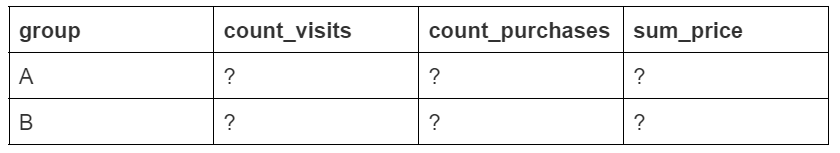
 
 
Для того, чтобы получить такую таблицу, сгруппируйте данные по признаку группы. В каждой группе рассчитайте следующие показатели:
* количество посещений (количество пользователей)
* количество совершенных покупок
* сумма всех покупок в группе

В полученной сгруппированной таблице переименуйте столбцы на **count_visits, count_purchases и sum_price**.

**Подсказка:**

*Для переименования столбцов можно использовать метод rename() с параметром columns, в который передается словарь. Ключи этого словаря - старые имена столбцов, а значения - новые.*

Чему на этот раз равно количество посещений сайта в группах А и B?


In [9]:
group_data = updated_data.groupby('group').agg({'user_id': 'count', 'purchase': 'sum', \
    'price': 'sum'}).rename(columns = {'user_id': 'count_visits', 'purchase': 'count_purshases', \
    'price': 'sum_price'})
group_data

,count_visits,count_purshases,sum_price
group,,,
A,145307,17487,1417780000
B,145381,17290,1533010000


Приведите промежуточные выводы по построенной таблице. Сопоставимо ли количество посещений обоих вариантов посадочной странице, можно ли говорить о сбалансированности выборок?

Количество посещений сопоставимо, разница составляет 0,05%. 

## **Задание 7.6.**

Добавьте в сгруппированную таблицу столбцы conversion - конверсия покупки (отношение количества покупок к количеству посещений сайта в каждой группе, выраженное в процентах) и mean_check - средний чек (отношение суммы покупок к количеству покупок в каждой группе).

* Чему равна конверсия в группах? Ответ приведите в процентах и округлите до сотых. Например, 75.12 %
* Чему равен средний чек в группах? Ответ приведите в рублях и округлите до целых. Например, 120519 рублей.

In [10]:
group_data['conversion'] = (group_data['count_purshases'] * 100 / group_data['count_visits']).round(2)
group_data['mean_check'] = (group_data['sum_price'] / group_data['count_purshases']).round(0)
group_data

,count_visits,count_purshases,sum_price,conversion,mean_check
group,,,,,
A,145307,17487,1417780000,12.03,81076.0
B,145381,17290,1533010000,11.89,88665.0


Приведите промежуточные выводы по таблице. По какому(им) показателю(ям) вариант А эффективнее варианта B и наоборот?

На первый взгляд по средним значениям можно видеть что конверсия в обеих группах сопоставима (разница менее 2%, группа А имеет лидирующее положение), а средний чек в группе В заметно выше (практически на 10%).

## **Задание 7.7.**

Теперь давайте сравним варианты по покупательской способности туров. Для этого постройте сводную таблицу, которая покажет зависимость количества продаж от группы и цены тура. 

In [11]:
pivot_data = pd.pivot_table(updated_data,
                            index = 'group',
                            columns = 'price',
                            values = 'purchase',
                            aggfunc = 'sum')
pivot_data

price,0,10000,60000,100000,150000,200000
group,,,,,,
A,0,5182,5271,1832,3478,1724
B,0,5201,1730,5227,3438,1694


Визуализируйте полученную сводную таблицу с помощью тепловой карты с аннотацией. 
Чему равно количество проданных туров за 60000 рублей в группах?

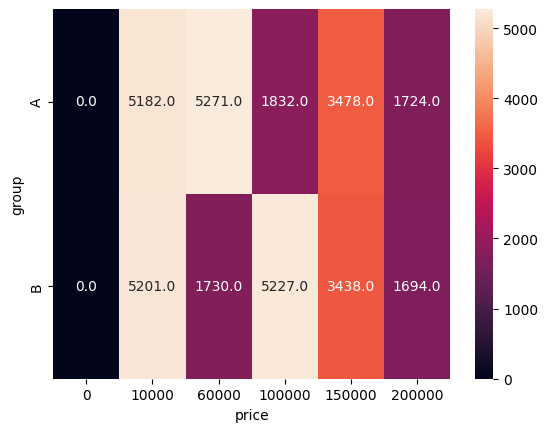

In [12]:
plot = sns.heatmap(pivot_data, annot= True, fmt=".1f")

Сделайте выводы по построенной таблице. По каким турам покупательская способность участников группы А выше, чем участников группы B и наоборот?

На тепловой карте видно что показатели для групп А и В по всем категориям идентичны за исключением категорий туров за 60 000 и 100 000. В данном случае категория А имеет более высокую результативность в ценовом диапазоне 60 000 рублей, а категория В - в ценовом диапазоне 100 000 рублей. 

## **Задание 7.8.**

Настало время поговорить о стабилизации кумулятивных метрик во времени. Но прежде, чем перейти к кумулятивным метрикам, нам необходимо построить таблицу с ежедневными данными результатов проведения A/B-тестирования.

Сгруппируйте данные по дате и группе тестирования. В каждой группе вычислите количество посещений страницы, количество покупок и сумму покупок. 

Добавьте в таблицу информацию о ежедневной конверсии (ежедневное количество покупок / ежедневное количество посещений) в группе и ежедневном среднем чеке (ежедневная сумма покупок / ежедневное количество покупок)
* Чему равна конверсия 3 января 2021 года? Ответ приведите в процентах и округлите до сотых.

* Чему равен средний чек 3 января 2021 года? Ответ приведите в рублях и округлите до целого.

In [13]:
dayly_group_data = updated_data.groupby(['group', 'date']).agg({'user_id': 'count', 'purchase': 'sum', \
    'price': 'sum'}).rename(columns = {'user_id': 'count_visits', 'purchase': 'count_purshases', \
    'price': 'sum_price'})
    
dayly_group_data['conversion'] = dayly_group_data['count_purshases'] / dayly_group_data['count_visits']
dayly_group_data['mean_check'] = dayly_group_data['sum_price'] / dayly_group_data['count_purshases']

print('Конверсия 3 января 2021 года была для группы А {}% при среднем чеке \
    {} рублей, для группы В - {}% при среднем чеке {} рублей'.format(
        round(dayly_group_data.loc[('A', '2021-01-03')]['conversion'] * 100, 2), 
        round(dayly_group_data.loc[('A', '2021-01-03')]['mean_check'], 0), 
        round(dayly_group_data.loc[('B', '2021-01-03')]['conversion'] * 100, 2), 
        round(dayly_group_data.loc[('B', '2021-01-03')]['mean_check'], 0)
        )
    )

Конверсия 3 января 2021 года была для группы А 11.34% при среднем чеке 82888.0 рублей, для группы В - 11.39% при среднем чеке 87480.0 рублей


## **Задание 7.9.** 

Добавьте в таблицу с ежедневными показателями кумулятивные признаки:
* кумулятивное количество посещений страницы
* кумулятивное количество покупок
* кумулятивную сумму покупок

Не забудьте при расчете кумулятивной суммы сгруппировать данные по группам. 

Вычислите кумулятивную конверсию и кумулятивный средний чек на основе полученных кумулятивных показателей. 

* Какая **кумулятивная** конверсия была в группе B на 20 января? Ответ приведите в процентах, округлив до сотых.
* Какой **кумулятивный** средний чек был в группе А на 12 января 2021 года? Ответ приведите в рублях, округлив до целых.

In [14]:
dayly_group_data.loc['A', 'cum_count'] = dayly_group_data.loc['A']['count_visits'].cumsum().values
dayly_group_data.loc['A', 'cum_purshase'] = dayly_group_data.loc['A']['count_purshases'].cumsum().values
dayly_group_data.loc['A', 'cum_price'] = dayly_group_data.loc['A']['sum_price'].cumsum().values
dayly_group_data.loc['B', 'cum_count'] = dayly_group_data.loc['B']['count_visits'].cumsum().values
dayly_group_data.loc['B', 'cum_purshase'] = dayly_group_data.loc['B']['count_purshases'].cumsum().values
dayly_group_data.loc['B', 'cum_price'] = dayly_group_data.loc['B']['sum_price'].cumsum().values

dayly_group_data['cum_conversion'] =  dayly_group_data['cum_purshase'] / dayly_group_data['cum_count']
dayly_group_data['cum_mean_price'] = dayly_group_data['cum_price'] / dayly_group_data['cum_purshase']
print(round(dayly_group_data.loc['B', '2021-01-20']['cum_conversion'] * 100, 2))
print(round(dayly_group_data.loc['A', '2021-01-12']['cum_mean_price'], 0))

11.9
81492.0


Постройте кумулятивные графики конверсии и среднего чека в каждой группе по дням. Сделайте выводы. Можно ли назвать A/B-тест завершенным - стабилизировались ли значения метрик во времени? Как соотносятся кумулятивные показатели в каждой группе?

<Axes:xlabel='date', ylabel='cum_mean_price'>

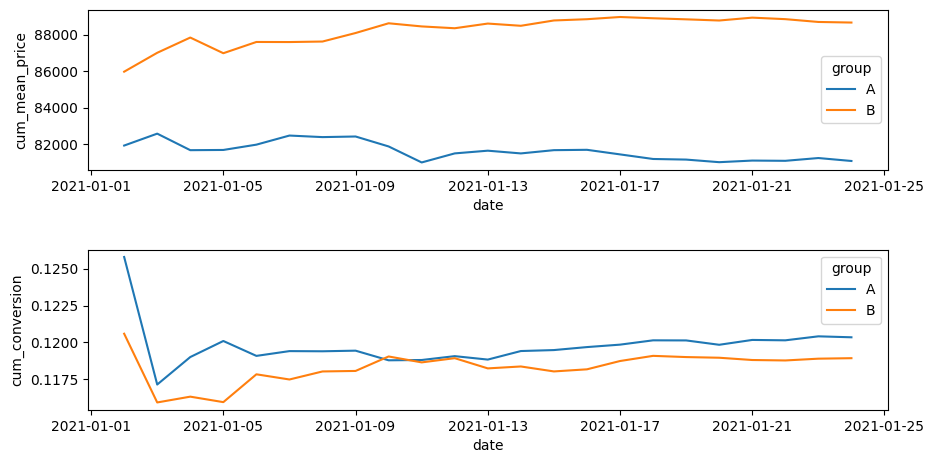

In [15]:
fig = plt.figure(figsize=(8, 4))
ax = fig.add_axes([1, 0, 1, 0.4])
ax1 = fig.add_axes([1, 0.6, 1, 0.4])
sns.lineplot(
    data=dayly_group_data, 
    x='date', 
    y='cum_conversion', 
    hue='group',
    ax=ax
    )
sns.lineplot(
    data=dayly_group_data, 
    x='date', 
    y='cum_mean_price', 
    hue='group',
    ax=ax1
    )


По графикам видно, что с 13 января кумулятивные метрики стабилизирются, соответственно длительность теста можно назвать достаточной. Так же по графикам видно что практически на протяжении всего эксперимента конверсия группы А несколько выше конверсии группы В, но при этом так же на всем протяжении эксперимента группа В показывает более высокий средний чек по сравнению с группой А.

## **Задание 7.10.**

Настало время переходить к проверке статистической значимости разницы между метриками в группах. Начнем с конверсии.

Какой тест вы примените для проверки гипотезы о равенстве конверсий в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Конверсии в группах А и B равны; 
* $H_1$: Конверсия в группе А больше чем конверсия в группе B;

Вычислите p-value вашего теста для конверсий в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$=0.05. 

In [16]:
from statsmodels.stats.proportion import proportions_ztest
H0 = 'Конверсии в группах А и B равны'
H1 = 'Конверсия в группе А выше, чем конверсия в группе B'
alpha = 0.05 # уровень значимости

_, p_value = proportions_ztest(
    count=group_data['count_purshases'], #число "успехов"
    nobs=group_data['count_visits'], #общее число наблюдений
    alternative='larger',
)

if (p_value < alpha): 
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

Принимаем нулевую гипотезу. Конверсии в группах А и B равны


Приведите свои выводы по результатам проведенного статистического теста. Есть ли статистическая разница между конверсиями в группах А и B?

Для проверки гипотезы равенства пропорций мы пользуемся z-критерием для пропорций. При проверке гипотез с помощью z-теста видно, что разница в конверсии групп А и В статистически незначима, соответственно мы принимаем гипотезу что конверсии равны.

## **Задание 7.11.**
Убедитесь в своих рассуждениях, построив 95%-ый доверительный интервал для конверсий и разницы между ними. Используйте $z_{крит}$ в своих расчетах

Укажите нижнюю и верхнюю границы доверительных интервалов. Границы приведите в процентах и округлите до 2 знака после запятой. Например: нижняя граница 89.24%, верхняя граница 91.25%.

In [17]:
from scipy.stats import norm

def proportions_conf_interval(n, x_p, gamma=0.95): 
    alpha = 1 - gamma # уровень значимости
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5 #погрешность
    lower_bound = x_p - eps # левая (нижняя) граница
    upper_bound = x_p + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound * 100, 2), round(upper_bound * 100, 2)

def diff_proportions_conf_interval(n, xp, gamma=0.95):
    alpha = 1 - gamma # уровень значимости
    diff = xp[1] - xp[0] # выборочная разница конверсий групп B и A
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (xp[0] * (1 - xp[0])/n[0] + xp[1] * (1 - xp[1])/n[1]) ** 0.5 # погрешность
    lower_bound = diff - eps # левая (нижняя) граница
    upper_bound = diff + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound *100, 2), round(upper_bound * 100, 2)

conf_interval_a = proportions_conf_interval(
n=dayly_group_data.loc['A', 'count_visits'].sum(), # размер выборки
x_p=dayly_group_data.loc['A', 'conversion'].mean() # выборочная пропорция
)

conf_interval_b = proportions_conf_interval(
n=dayly_group_data.loc['B', 'count_visits'].sum(), # размер выборки
x_p=dayly_group_data.loc['B', 'conversion'].mean() # выборочная пропорция
)
print('Доверительный интервал для конверсии группы А: {}'.format(conf_interval_a))
print('Доверительный интервал для конверсии группы B: {}'.format(conf_interval_b))

# размеры выборок групп А и B
n = [dayly_group_data.loc['A', 'count_visits'].sum(), \
    dayly_group_data.loc['B', 'count_visits'].sum()]
# выборочная пропорция групп A и B
xp = [dayly_group_data.loc['A', 'conversion'].mean(), \
    dayly_group_data.loc['B', 'conversion'].mean()]
# строим доверительный интервал для разности конверсий
diff_inverval = diff_proportions_conf_interval(n, xp)
print('Доверительный интервал для разности конверсий: {}'.format(diff_inverval))


Доверительный интервал для конверсии группы А: (11.88, 12.21)
Доверительный интервал для конверсии группы B: (11.73, 12.06)
Доверительный интервал для разности конверсий: (-0.38, 0.09)


In [18]:
def proportions_conf_interval(n, x_p, gamma=0.95): 
    alpha = 1 - gamma # уровень значимости
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5 #погрешность
    lower_bound = x_p - eps # левая (нижняя) граница
    upper_bound = x_p + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound * 100, 2), round(upper_bound * 100, 2)

def diff_proportions_conf_interval(n, xp, gamma=0.95):
    alpha = 1 - gamma # уровень значимости
    diff = xp[1] - xp[0] # выборочная разница конверсий групп B и A
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (xp[0] * (1 - xp[0])/n[0] + xp[1] * (1 - xp[1])/n[1]) ** 0.5 # погрешность
    lower_bound = diff - eps # левая (нижняя) граница
    upper_bound = diff + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound *100, 2), round(upper_bound * 100, 2)

conf_interval_a = proportions_conf_interval(
n=updated_data[updated_data['group'] == 'A']['user_id'].count(), # размер выборки
x_p=updated_data[updated_data['group'] == 'A']['purchase'].sum() / updated_data[updated_data['group'] == 'A']['user_id'].count() # выборочная пропорция
)

conf_interval_b = proportions_conf_interval(
n=updated_data[updated_data['group'] == 'B']['user_id'].count(), # размер выборки
x_p=updated_data[updated_data['group'] == 'B']['purchase'].sum() / updated_data[updated_data['group'] == 'B']['user_id'].count() # выборочная пропорция
)
print('Доверительный интервал для конверсии группы А: {}'.format(conf_interval_a))
print('Доверительный интервал для конверсии группы B: {}'.format(conf_interval_b))

# размеры выборок групп А и B
n = [updated_data[updated_data['group'] == 'A']['user_id'].count(), \
    updated_data[updated_data['group'] == 'B']['user_id'].count()]
# выборочная пропорция групп A и B
xp = [updated_data[updated_data['group'] == 'A']['purchase'].sum() / updated_data[updated_data['group'] == 'A']['user_id'].count(), \
    updated_data[updated_data['group'] == 'B']['purchase'].sum() / updated_data[updated_data['group'] == 'B']['user_id'].count()]
# строим доверительный интервал для разности конверсий
diff_inverval = diff_proportions_conf_interval(n, xp)
print('Доверительный интервал для разности конверсий: {}'.format(diff_inverval))

Доверительный интервал для конверсии группы А: (11.87, 12.2)
Доверительный интервал для конверсии группы B: (11.73, 12.06)
Доверительный интервал для разности конверсий: (-0.38, 0.09)


Проинтерпретируйте построенные доверительные интервалы для конверсий в группах. Есть ли перекрытие между доверительными интервалами для групп? Есть ли статистическая разница между конверсиями в группах А и B?

Границы доверительного интервала разности конверсий имеют разные знаки, это означает что статистической разницы между конверсиями в группах А и В нет.
Выше приведены два варианта расчета доверительного интервала, т.к. по первому (расчет из сгруппированной по дням таблице) имел несовпадающие с ответом границы доверительного интервала для группы А, при этом доверительные интервалы для группы В и разницы конверсий совпали с верными ответами. Учитывая что для группы А и В код совершенно одинаковый и доверительный интервал разницы конверсий тоже совпадает возникла мысль что проблема при округлении в вычислениях. При расчете из исходного очищенного датафрейма результат совпал с ответами на платформе.


## **Задание 7.12.**

Ранее мы построили таблицу с ежедневными показателями. Теперь она нам снова понадобится, так как нас интересует ежедневный средний чек.

Проверьте гипотезу о нормальности распределения ежедневного среднего чека в каждой из групп тестирования. 

* Какой тест вы примените  для проверки гипотезы о нормальности распределения ежедневного среднего чека?
* Как будут звучать нулевая и альтернативная гипотезы?
* Каковы результаты статистического теста с уровнем значимости $\alpha$ =0.05?

In [20]:
from scipy.stats import shapiro

# нулевая и альтернативная гипотезы
H0 = 'Распределения в обеих группах нормальные'
H1 = 'Распределение в одной или обеих группах отлично от нормального'
alpha = 0.05 # уровень значимости

# вычисляем результат теста Шапиро-Уилка для выборок
shapiro_result_a = shapiro(dayly_group_data.loc['A', 'mean_check'])
shapiro_result_b = shapiro(dayly_group_data.loc['B', 'mean_check'])

print('p-value группы А', round(shapiro_result_a.pvalue, 2))
print('p-value группы B', round(shapiro_result_b.pvalue, 2))
# сравниваем полученное p-value с уровнем значимости
if shapiro_result_a.pvalue < alpha or shapiro_result_b.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value группы А 0.25
p-value группы B 0.09
Принимаем нулевую гипотезу. Распределения в обеих группах нормальные


## **Задание 7.13.**
Настало время сравнить варианты дизайна страницы по метрике среднего чека. 

Какой тест вы примените для проверки гипотезы о равенстве средних чеков по дням в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Ежедневные средние чеки в группах А и B равны; 
* $H_1$: Ежедневный средний чек в группе А меньше чем в группе B;

Вычислите p-value вашего теста для ежедневного среднего чека в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$ =0.05. 

In [21]:
from scipy.stats import ttest_ind
# нулевая и альтернативная гипотезы
H0 = 'Средний чек в группах одинаково'
H1 = 'Средний чек в группе А меньше, чем в группе B'
alpha = 0.05 #уровень значимости
#вычисляем результат T-теста для выборок
results = ttest_ind(
    a=dayly_group_data.loc['A', 'mean_check'],
    b=dayly_group_data.loc['B', 'mean_check'], 
    alternative='less'
)
print('p-value:', round(results.pvalue, 2))
 
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value: 0.0
Отвергаем нулевую гипотезу. Средний чек в группах одинаково
Альтернативная гипотеза. H1: Средний чек в группе А меньше, чем в группе B


 Приведите свои выводы по проведенному статистическому тесту. Есть ли статистическая разница между ежедневными средними чеками в группах А и B?

Согласно проведенному Т-тесту статистически средний чек в группе А меньше среднего чека в группе В.

## **Задание 7.14.**

Постройте 95%-ый доверительный интервал для среднего чека в каждой группе. Так как выборка средних чеков небольшая, используйте  $t_{крит}$ в своих расчетах.

Укажите нижнюю границу доверительного интервала для истинного среднего чека каждой из групп. Ответ приведите в процентах и округлите до целого.

In [41]:
dayly_group_data.loc['A', 'mean_check'].std()

3096.284254515444

In [42]:
from scipy.stats import t
def mean_check_interval(n, x_std, x_mean, gamma=0.95): 
    alpha = 1 - gamma # уровень значимости
    k = n - 1
    t_crit = -t.ppf(alpha/2, k) # t-критическое
    eps = t_crit * x_std/(n ** 0.5) # погрешность
    lower_bound = x_mean - eps # левая (нижняя) граница
    upper_bound = x_mean + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound, 0), round(upper_bound, 0)

mean_check_interval_a = mean_check_interval(dayly_group_data.loc['A'].shape[0],
                                            x_std=dayly_group_data.loc['A', 'mean_check'].std(),
                                            x_mean=dayly_group_data.loc['A', 'mean_check'].mean()
                                            )
mean_check_interval_b = mean_check_interval(dayly_group_data.loc['B'].shape[0],
                                            x_std=dayly_group_data.loc['B', 'mean_check'].std(),
                                            x_mean=dayly_group_data.loc['B', 'mean_check'].mean()
                                            )

print('Доверительный интервал для конверсии группы А: {}'.format(mean_check_interval_a))
print('Доверительный интервал для конверсии группы B: {}'.format(mean_check_interval_b))

Доверительный интервал для конверсии группы А: (79630.0, 82308.0)
Доверительный интервал для конверсии группы B: (87626.0, 89526.0)


Проинтерпретируйте построенные доверительные интервалы для ежедневных средних чеков в группах. Есть ли между ними пересечения?

Доверительные интервалы средних чеков не пересекаются, это означает что в подавляющем большинстве случаев средний чек группы В выше среднего чека группы А.

## **Сделайте общий вывод по результатам A/B-теста**

Какой варианта дизайна посадочной страницы является более эффективным в комплексе по метрикам конверсии и среднего чека и почему? 

Согласно проведенному исследованию результатов А/В тестирования, можно сделать вывод, что тест проведен корректно, выборки равнозначны, кумулятивные метрики отслеживаемых показателей стабилизировались во времени. Согласно полученным данным обе посадочные страницы имеют одинаковую конверсию, однако версия посадочной страницы В показывает средний чек выше примерно на 10%, чем версия А. Таким образом можно рекомендовать к внедрению версию страницы В.